In [1]:
import numpy as np
import scipy as sp
import scipy.stats as sts
import pandas as pd
import geopandas as gpd

import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import time

np.random.seed(24) # 42

/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwd

# train data and dce hp mp:

In [2]:
pkl_file = open('train_df_sce.pkl', 'rb')
df = pickle.load(pkl_file)
pkl_file.close()

# pkl_file = open('dce_hp_trace_mu.pkl', 'rb')
# dce_hp_trace_mu = pickle.load(pkl_file)
# pkl_file.close()

pkl_file = open('dce_hp_mp_mu.pkl', 'rb')
dce_hp_mp_mu = pickle.load(pkl_file)
pkl_file.close()


In [3]:
dce_hp_mp_mu

{'η': array([0.58658564]), 'σ': array([0.22515332]), 'ℓ': array([3.23071786])}

In [4]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 442008 entries, 0 to 442007
Data columns (total 12 columns):
gid         442008 non-null int64
xcoord      442008 non-null float64
ycoord      442008 non-null float64
col         442008 non-null float64
row         442008 non-null float64
geometry    442008 non-null object
year        442008 non-null int64
gwno        442008 non-null float64
best        442008 non-null float64
log_best    442008 non-null float64
sce_mu      442008 non-null float64
sce_var     442008 non-null float64
dtypes: float64(9), int64(2), object(1)
memory usage: 43.8+ MB


# From sce mu to dce mu:
repertation, but this tim you have the mp to use for the prediction and don't need to estimate those.

In [5]:
def get_X_new(step_size = 0.25, maxyear = 2017):
    step = step_size
    min_year = df['year'].min()
    max_year = maxyear #df['year'].max() # fordi du har 

    X_new = np.arange(min_year,max_year + step, step)[:,None]
    
    return(X_new)

In [6]:
# new try
def get_X_y_index():
    
    df_sort = df.sort_values(['gid','year'])
    
    X = np.array(df_sort['year'])[:,None]
    y = np.array(df_sort['sce_mu'])
    index = np.array(df_sort['gid'])
    
    return(X,y,index)

In [7]:
def get_gid_list():
    
    gid_list = []

    for i in df['gid'].unique():
        
        timeline  = df[df['gid'] == i]
        if np.count_nonzero(timeline['log_best']) >= 2:
            gid_list.append(i)
        
    gid_list = np.random.choice(gid_list, 100) # number of samples for hyper parameter estimates.
    
    return(gid_list)

In [8]:
def get_event_timelines():
    df_sub = df[df['gid'].isin(gid_list)].sort_values(['gid','year'])
    
    event_X = np.array(df_sub['year'])[:,None]
    event_y = np.array(df_sub['sce_mu'])
    event_index = np.array(df_sub['gid'])
    
    return(event_X, event_y, event_index)

In [9]:
X_new = get_X_new(1,2017)
X,y,index = get_X_y_index()
gid_list = get_gid_list()
X1,y1,index1 = get_event_timelines()

# Visualisation of the data

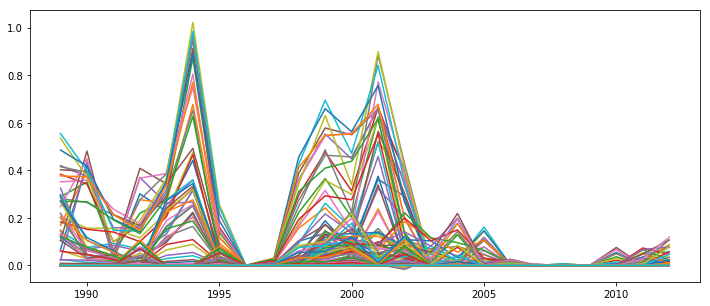

In [10]:
# Random:

fig = plt.figure(figsize=(12,5))

for i, j in enumerate(np.unique(index)[0:100]):
    plt.plot(X[index == j], y[index==j])
    
plt.show()



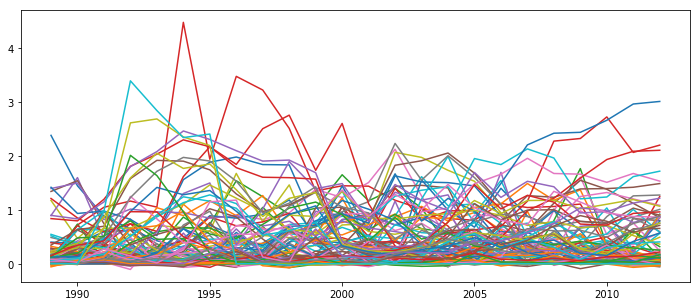

In [11]:
# Obs with 2 or more events doing timeline for estimation of hyper parameters.

fig = plt.figure(figsize=(12,5))

for i, j in enumerate(np.unique(index1)[0:100]):
    plt.plot(X1[index1 == j], y1[index1==j])
    
plt.show()

# Estimation
### Define and illlustrate hyper-priors:

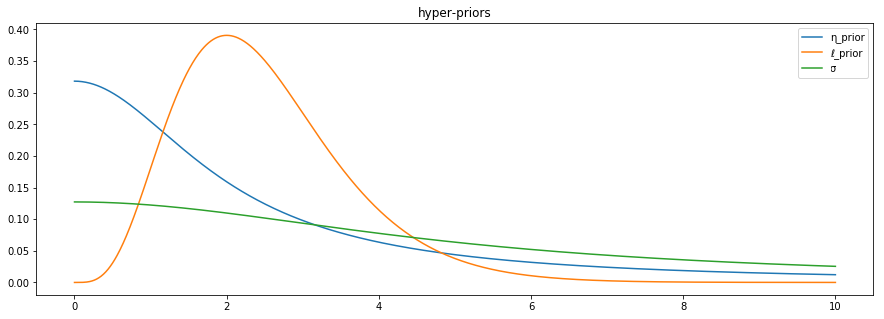

In [12]:
η_beta = 2
ℓ_beta = 2
ℓ_alpha = 5
σ_beta = 5

grid = np.linspace(0,10,1000)
priors = [
    ('η_prior', pm.HalfCauchy.dist(beta=η_beta)),
    ('ℓ_prior', pm.Gamma.dist(alpha=ℓ_alpha , beta=ℓ_beta )),
    ('σ', pm.HalfCauchy.dist(beta=σ_beta))]

plt.figure(figsize= [15,5])
plt.title('hyper-priors')


for i, prior in enumerate(priors):
    plt.plot(grid, np.exp(prior[1].logp(grid).eval()), label = prior[0])

plt.legend()
plt.show()

# from sce mu to dce mu model:

In [13]:
# step0

time0 = time.time()

with pm.Model() as model:
    
    # trend
    ℓ = pm.Gamma("ℓ", alpha=ℓ_alpha , beta=ℓ_beta, shape = 1)
    η = pm.HalfCauchy("η", beta=η_beta, shape = 1)
    
    # noise model
    σ = pm.HalfCauchy("σ", beta=σ_beta, shape = 1)
    
    # Cov func.
    cov = η **2 * pm.gp.cov.ExpQuad(1, ℓ)
    
    # GP
    gp = pm.gp.Marginal(cov_func=cov)

    
    # sample: 
    for i, j in enumerate(np.unique(index1)):
        
#         mean = pm.gp.mean.Constant(np.mean(y[index == j]))
                
        y_ = gp.marginal_likelihood("y" + str(i) + "_", X=X1[index1 == j], y=y1[index1 == j], noise= σ)
        

/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [14]:
dce_hp_mp_mu

{'η': array([0.58658564]), 'σ': array([0.22515332]), 'ℓ': array([3.23071786])}

In [15]:
# time0 = time.time()

# with model:
#     mp = pm.find_MAP()
    
# time1 = time.time()
# step0t = (time1 - time0)/60
# print(step0t)

# mp

# All timelines:

Run it teo turns due to memory-leak and not enough ram...

# 1)

In [18]:
mp=dce_hp_mp_mu

time_0 = time.time()

mu_list = []
var_list = []

print('Started\n')

for i, j in enumerate(np.unique(index)[0:10000]):
    
    mu, var = gp.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X[index == j], 'y' : y[index == j], 'noise' : σ },diag=True)
    
    mu_list.append(mu)
    var_list.append(var)
    
    if str(i)[-2:] == '00':
        print('{}/{}'.format(i,np.unique(index).shape[0]), end = '-')

print('\nEnded\n')
    
    
time_1 = time.time()

time_step1 = (time_1 - time_0)/60

print('total {} min'.format(time_step1))

Started



/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future 

100/18417-200/18417-300/18417-400/18417-500/18417-600/18417-700/18417-800/18417-900/18417-1000/18417-1100/18417-1200/18417-1300/18417-1400/18417-1500/18417-1600/18417-1700/18417-1800/18417-1900/18417-2000/18417-2100/18417-2200/18417-2300/18417-2400/18417-2500/18417-2600/18417-2700/18417-2800/18417-2900/18417-3000/18417-3100/18417-3200/18417-3300/18417-3400/18417-3500/18417-3600/18417-3700/18417-3800/18417-3900/18417-4000/18417-4100/18417-4200/18417-4300/18417-4400/18417-4500/18417-4600/18417-4700/18417-4800/18417-4900/18417-5000/18417-5100/18417-5200/18417-5300/18417-5400/18417-5500/18417-5600/18417-5700/18417-5800/18417-5900/18417-6000/18417-6100/18417-6200/18417-6300/18417-6400/18417-6500/18417-6600/18417-6700/18417-6800/18417-6900/18417-7000/18417-7100/18417-7200/18417-7300/18417-7400/18417-7500/18417-7600/18417-7700/18417-7800/18417-7900/18417-8000/18417-8100/18417-8200/18417-8300/18417-8400/18417-8500/18417-8600/18417-8700/18417-8800/18417-8900/18417-9000/18417-9100/18417-9200/184

# PICKLE MU_LIST and VAR_LIST

In [19]:
file_path = 'dce_mu_list_0_10000.pkl'.format(i)
output = open(file_path, 'wb') # still not working right!!
pickle.dump(mu_list, output)
output.close()

In [20]:
file_path = 'dce_var_list_0_10000.pkl'.format(i)
output = open(file_path, 'wb') # still not working right!!
pickle.dump(var_list, output)
output.close()

In [21]:
len(mu_list)

10000

In [22]:
len(var_list)

10000

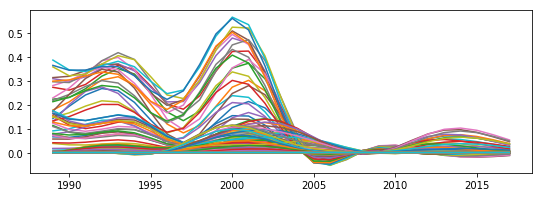

In [40]:
plt.figure(figsize = [9,3])

for i in np.arange(0,100):
    plt.plot(X_new,mu_list[i])
    
plt.show()

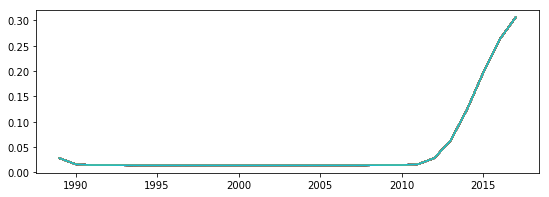

In [43]:
plt.figure(figsize = [9,3])

for i in np.arange(0,100):
    plt.plot(X_new,var_list[i])
    
plt.show()

### Pickle test

In [45]:
pkl_file = open('dce_mu_list_0_10000.pkl', 'rb')
pickle_test_mu_list = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('dce_var_list_0_10000.pkl', 'rb')
pickle_test_var_list = pickle.load(pkl_file)
pkl_file.close()

In [47]:
len(pickle_test_mu_list)

10000

In [48]:
len(pickle_test_var_list)

10000

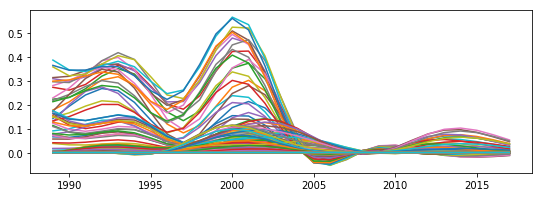

In [42]:
plt.figure(figsize = [9,3])

for i in np.arange(0,100):
    plt.plot(X_new,pickle_test_mu_list[i])
    
plt.show()

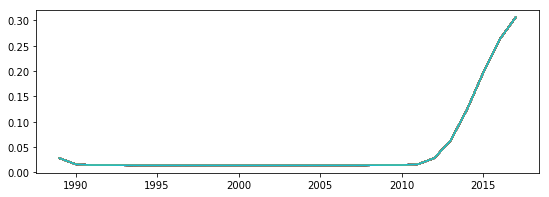

In [46]:
plt.figure(figsize = [9,3])

for i in np.arange(0,100):
    plt.plot(X_new,pickle_test_var_list[i])
    
plt.show()

# test:

In [16]:
pkl_file = open('dce_mu_list_0_10000.pkl', 'rb')
pickle_test_mu_list = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('dce_var_list_0_10000.pkl', 'rb')
pickle_test_var_list = pickle.load(pkl_file)
pkl_file.close()

In [17]:
len(pickle_test_mu_list)

10000

In [18]:
len(pickle_test_var_list)

10000

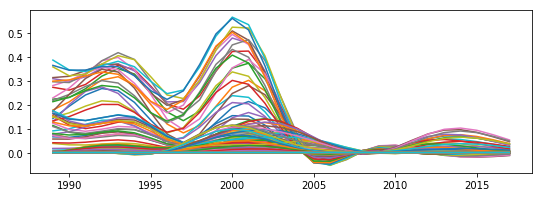

In [19]:
plt.figure(figsize = [9,3])

for i in np.arange(0,100):
    plt.plot(X_new,pickle_test_mu_list[i])
    
plt.show()

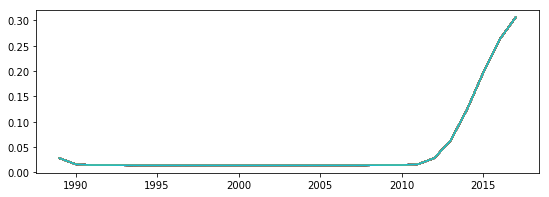

In [20]:
plt.figure(figsize = [9,3])

for i in np.arange(0,100):
    plt.plot(X_new,pickle_test_var_list[i])
    
plt.show()

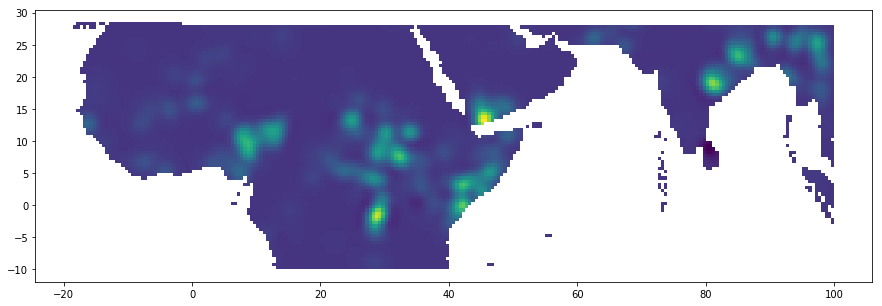

In [50]:
dce_mu_train_years = np.array(pickle_test_mu_list)[0:10000,0:24].flatten() # no new x years
# you just use the original df when you want to add extrapolated years
df_sub_0_10k = df.sort_values(['gid','year'])[0:240000].copy()
df_sub_0_10k['dce_mu'] = dce_mu_train_years

df_sub_0_10k[df_sub_0_10k['year']==2012].plot(column = 'dce_mu', figsize=(15, 15))
plt.show()

# 2)

In [ ]:
mp=dce_hp_mp_mu

time_0 = time.time()

mu_list_10k = []
var_list_10k = []

print('Started\n')

for i, j in enumerate(np.unique(index)[10000:]):
    
    mu, var = gp.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X[index == j], 'y' : y[index == j], 'noise' : σ },diag=True)
    
    mu_list_10k.append(mu)
    var_list_10k.append(var)
    
    if str(i)[-2:] == '00':
        print('{}/{}'.format(i,np.unique(index).shape[0]), end = '-')

print('\nEnded\n')
    
    
time_1 = time.time()

time_step1 = (time_1 - time_0)/60

print('total {} min'.format(time_step1))

# Viz test)

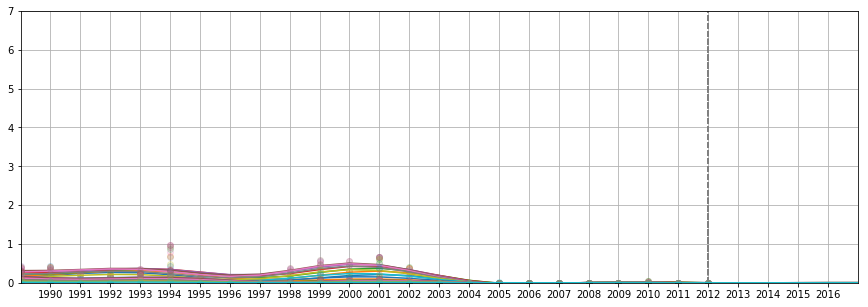

In [94]:
fig = plt.figure(figsize=(15,5))

start = 0
end = 20

for i, j in enumerate(np.unique(index)[start:end]):
    
    i = i + start
    
    color = 'C' + str(i)[-1] # reiterates after 9
    
    plt.plot(X_new, mu_list[i], color = color)
    plt.plot(X[index == j], y[index == j], 'o' , ms=6, alpha=0.2, color = color)
    plt.vlines(X.max(),0,y.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X2.max()))



plt.ylim(0,7)
plt.xlim(X_new.min(),X_new.max())

plt.xticks(np.arange(1990,2017,1))
plt.grid()

plt.show()

# OLD:

# Visualisation of the data

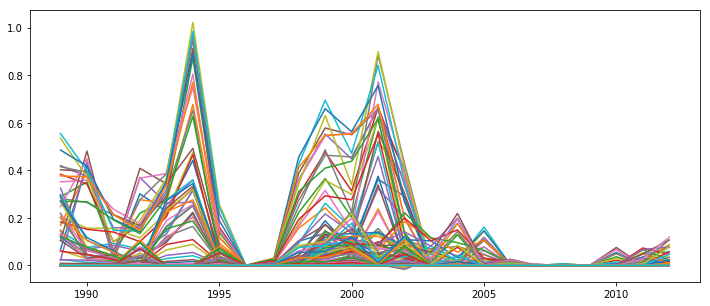

In [22]:
# Random:

fig = plt.figure(figsize=(12,5))

for i, j in enumerate(np.unique(index)[0:100]):
    plt.plot(X[index == j], y[index==j])
    
plt.show()



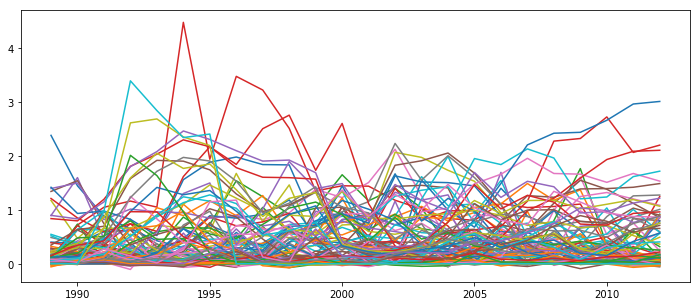

In [15]:
# Obs with 2 or more events doing timeline for estimation of hyper parameters.

fig = plt.figure(figsize=(12,5))

for i, j in enumerate(np.unique(index1)[0:100]):
    plt.plot(X1[index1 == j], y1[index1==j])
    
plt.show()

# Estimation

### Define and illlustrate hyper-priors:

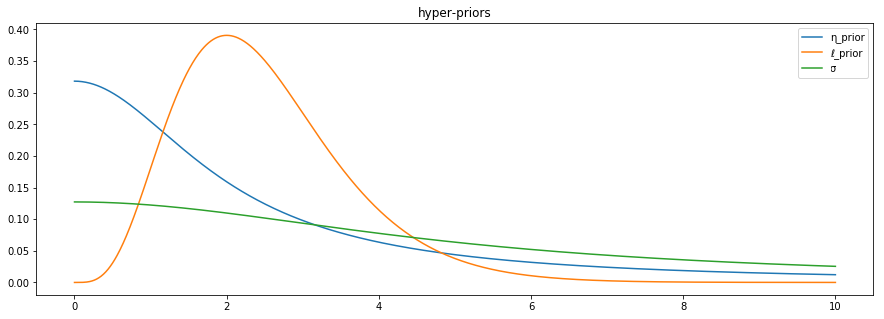

In [4]:
η_beta = 2
ℓ_beta = 2
ℓ_alpha = 5
σ_beta = 5

grid = np.linspace(0,10,1000)
priors = [
    ('η_prior', pm.HalfCauchy.dist(beta=η_beta)),
    ('ℓ_prior', pm.Gamma.dist(alpha=ℓ_alpha , beta=ℓ_beta )),
    ('σ', pm.HalfCauchy.dist(beta=σ_beta))]

plt.figure(figsize= [15,5])
plt.title('hyper-priors')


for i, prior in enumerate(priors):
    plt.plot(grid, np.exp(prior[1].logp(grid).eval()), label = prior[0])

plt.legend()
plt.show()

### The model
So you need to find uot if you should get map from only a subset of X. Like all with more then two years of bieng near a conflcit.
you can also tyr the sparse implimentation.

# Get map est and sample est:
## One component 

In [5]:
# step0

time0 = time.time()

with pm.Model() as model:
    
    # trend
    ℓ = pm.Gamma("ℓ", alpha=ℓ_alpha , beta=ℓ_beta, shape = 1)
    η = pm.HalfCauchy("η", beta=η_beta, shape = 1)
    
    # noise model
    σ = pm.HalfCauchy("σ", beta=σ_beta, shape = 1)
    
    # Cov func.
    cov = η **2 * pm.gp.cov.ExpQuad(1, ℓ)
    
    # GP
    gp = pm.gp.Marginal(cov_func=cov)

    
    # sample: 
    for i, j in enumerate(np.unique(index1)):
        
#         mean = pm.gp.mean.Constant(np.mean(y[index == j]))
                
        y_ = gp.marginal_likelihood("y" + str(i) + "_", X=X1[index1 == j], y=y1[index1 == j], noise= σ)
        

/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


In [7]:
time1 = time.time()

with model:
    trace = pm.sample()
    
time1 = time.time()
stepallt = (time1 - time0)/60
print('time total: {}min'.format(stepallt))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexin

time total: 34.04308899243673min


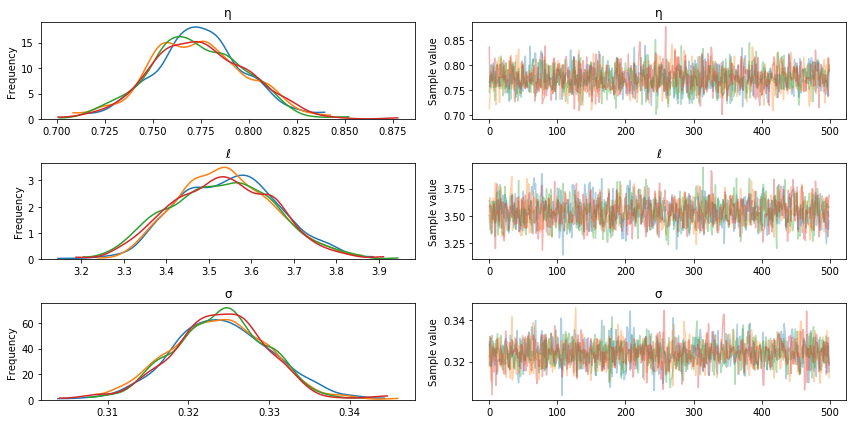

In [8]:
pm.traceplot(trace, varnames=['η', 'ℓ', 'σ'])
plt.show()

In [9]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
ℓ__0,3.536661,0.118202,0.003075,3.320114,3.773437,1543.329140,1.000456
η__0,0.773707,0.024246,0.000610,0.726351,0.820273,1745.814644,1.000064
σ__0,0.323930,0.005947,0.000149,0.312455,0.335104,1832.323315,0.999625


In [10]:
mp = {'ℓ' : np.array([pm.summary(trace)['mean'].iloc[0]]),  
      'η': np.array([pm.summary(trace)['mean'].iloc[1]]), 
      'σ' : np.array([pm.summary(trace)['mean'].iloc[2]])}

In [11]:
mp

{'η': array([0.77370715]), 'σ': array([0.32393014]), 'ℓ': array([3.53666056])}

In [12]:
time2 = time.time()
step0t = (time1 - time0)/60
step1t = (time2 - time1)/60

stepallt = (time2 - time0)/60

print('step 0: {}min \n step 1: {} \n time total: {}min'.format(step0t, step1t, stepallt))

step 0: 34.04308899243673min 
 step 1: 0.05293932358423869 
 time total: 34.09602831602096min


In [6]:
# if you alredy run the above, but somthing happend:

mp = {'ℓ' : np.array([3.53666056]),  
      'η': np.array([0.77370715]), 
      'σ' : np.array([0.32393014])}

mp

{'η': array([0.77370715]), 'σ': array([0.32393014]), 'ℓ': array([3.53666056])}

# Prediction
## Obs used to estimate hyper parameters.

In [13]:
time_0 = time.time()

mu_list = []
var_list = []

for i, j in enumerate(np.unique(index1)):
    mu, var = gp.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X1[index1 == j], 'y' : y1[index1 == j], 'noise' : σ }, diag=True)
    
    mu_list.append(mu)
    var_list.append(var)
    
    print('{}/{}'.format(i,np.unique(index1).shape[0]), end = '-')
    
    
    
time_1 = time.time()

time_step1 = (time_1 - time_0)/60

print('total {} min'.format(time_step1))

/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future 

0/99-1/99-2/99-3/99-4/99-5/99-6/99-7/99-8/99-9/99-10/99-11/99-12/99-13/99-14/99-15/99-16/99-17/99-18/99-19/99-20/99-21/99-22/99-23/99-24/99-25/99-26/99-27/99-28/99-29/99-30/99-31/99-32/99-33/99-34/99-35/99-36/99-37/99-38/99-39/99-40/99-41/99-42/99-43/99-44/99-45/99-46/99-47/99-48/99-49/99-50/99-51/99-52/99-53/99-54/99-55/99-56/99-57/99-58/99-59/99-60/99-61/99-62/99-63/99-64/99-65/99-66/99-67/99-68/99-69/99-70/99-71/99-72/99-73/99-74/99-75/99-76/99-77/99-78/99-79/99-80/99-81/99-82/99-83/99-84/99-85/99-86/99-87/99-88/99-89/99-90/99-91/99-92/99-93/99-94/99-95/99-96/99-97/99-98/99-total 7.383835303783417 min


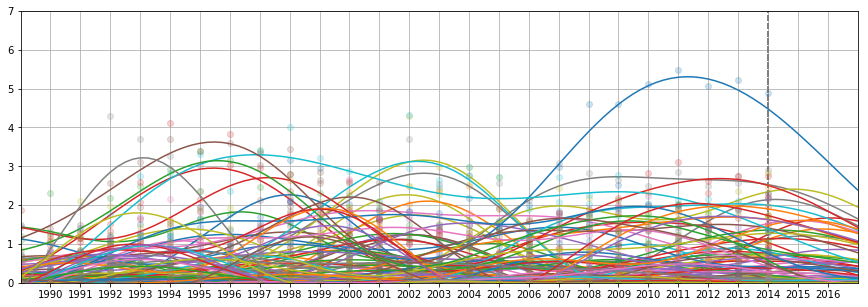

In [14]:
fig = plt.figure(figsize=(15,5))

start = 0
end = 100

for i, j in enumerate(np.unique(index1)[start:end]):
    
    i = i + start
    
    color = 'C' + str(i)[-1] # reiterates after 9
    
    plt.plot(X_new, mu_list[i], color = color)
    plt.plot(X1[index1 == j], y1[index1 == j], 'o' , ms=6, alpha=0.2, color = color)
    plt.vlines(X1.max(),0,y1.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X1.max()))



plt.ylim(0,7)
plt.xlim(X_new.min(),X_new.max())

plt.xticks(np.arange(1990,2017,1))
plt.grid()

plt.show()

## Prediction new timelines (test):

In [15]:
# train_df_sub = train_df.sample(100)
new_gid_list = df['gid'].sample(100)

train_df_sub_sub = train_df[train_df['gid'].isin(new_gid_list)]

X2 = np.array(train_df_sub_sub['year'])[:,None]
y2 = np.array(train_df_sub_sub['mu'])
index2 = np.array(train_df_sub_sub['gid'])

In [16]:
time_0 = time.time()

mu_list = []
var_list = []

for i, j in enumerate(np.unique(index2)):
    
    mu, var = gp.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X2[index2 == j], 'y' : y2[index2 == j], 'noise' : σ },diag=True)
    
    mu_list.append(mu)
    var_list.append(var)
    
    print('{}/{}'.format(i,np.unique(index2).shape[0]), end = '-')
    
    
time_1 = time.time()

time_step1 = (time_1 - time_0)/60

print('total {} min'.format(time_step1))

/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


0/100-1/100-2/100-3/100-4/100-5/100-6/100-7/100-8/100-9/100-10/100-11/100-12/100-13/100-14/100-15/100-16/100-17/100-18/100-19/100-20/100-21/100-22/100-23/100-24/100-25/100-26/100-27/100-28/100-29/100-30/100-31/100-32/100-33/100-34/100-35/100-36/100-37/100-38/100-39/100-40/100-41/100-42/100-43/100-44/100-45/100-46/100-47/100-48/100-49/100-50/100-51/100-52/100-53/100-54/100-55/100-56/100-57/100-58/100-59/100-60/100-61/100-62/100-63/100-64/100-65/100-66/100-67/100-68/100-69/100-70/100-71/100-72/100-73/100-74/100-75/100-76/100-77/100-78/100-79/100-80/100-81/100-82/100-83/100-84/100-85/100-86/100-87/100-88/100-89/100-90/100-91/100-92/100-93/100-94/100-95/100-96/100-97/100-98/100-99/100-total 8.861433943112692 min


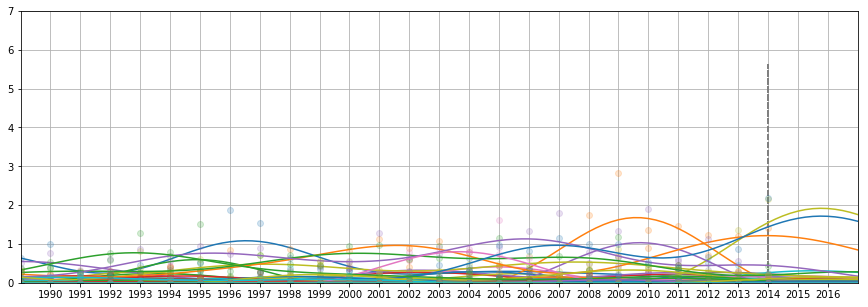

In [17]:
fig = plt.figure(figsize=(15,5))

start = 0
end = 100

for i, j in enumerate(np.unique(index2)[start:end]):
    
    i = i + start
    
    color = 'C' + str(i)[-1] # reiterates after 9
    
    plt.plot(X_new, mu_list[i], color = color)
    plt.plot(X2[index2 == j], y2[index2 == j], 'o' , ms=6, alpha=0.2, color = color)
    plt.vlines(X2.max(),0,y2.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X2.max()))



plt.ylim(0,7)
plt.xlim(X_new.min(),X_new.max())

plt.xticks(np.arange(1990,2017,1))
plt.grid()

plt.show()

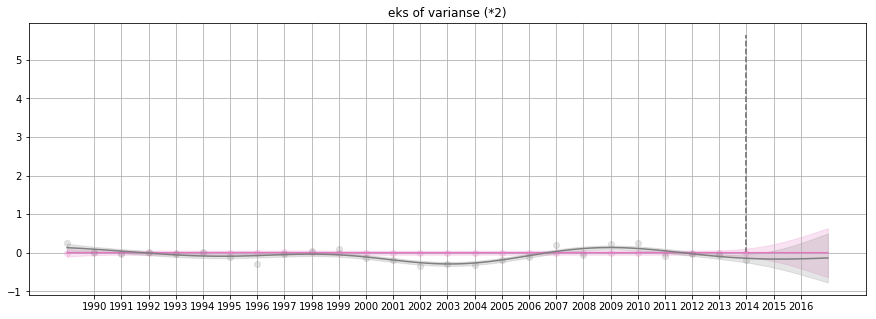

In [18]:
fig = plt.figure(figsize=(15,5))

start = 6
end = 8

for i, j in enumerate(np.unique(index2)[start:end]):
    
    i = i + start
    
    color = 'C' + str(i)[-1] # reiterates after 9
    
    plt.plot(X_new, mu_list[i], color = color)

    
    plt.fill_between(X_new.flatten(), mu_list[i] + (var_list[i] * 2), mu_list[i] - (var_list[i] * 2) , color = color, alpha = 0.2)

    plt.plot(X2[index2 == j], y2[index2 == j], 'o' , ms=6, alpha=0.2, color = color)
    plt.vlines(X2.max(),0,y2.max()*2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X2.max()))



# plt.ylim(0,7)
# plt.xlim(X_new.min(),X_new.max())

plt.title('eks of varianse (*2)')
plt.xticks(np.arange(1990,2017,1))
plt.grid()

plt.show()

# Predict all timelines.

In [ ]:
df['gid'].unique().shape

(18417,)

In [ ]:
# Again, I do not have enough ram to run every thing at once. Thus the code below is split up in runds.

In [ ]:
time_0 = time.time()

# list for estimations
mu_list = []
var_list = []

 # just to keep 100% track of the timelines.
index_list = []
year_list = []

print('Started..\n')
for i, j in enumerate(np.unique(index)):
    
    mu, var = gp.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X[index == j], 'y' : y[index == j], 'noise' : σ },diag=True)
    
    mu_list.append(mu)
    var_list.append(var)
    index_list.append(j)
    year_list.append(X_new)
    
    if str(i)[-2:] == '00':
        print('{}/{}'.format(i,np.unique(index).shape[0]), end = '-')
        
        # save a backup-dict at every mark (100)
        estimation_dict = {} # use new one at every mark
        estimation_dict['mu'] = np.array(mu_list)
        estimation_dict['var'] = np.array(var_list)
        estimation_dict['index'] = np.array(index_list)
        estimation_dict['year'] = np.array(year_list)
        
        file_path = 'space_time_pkls/space_time_dict{}.pkl'.format(i)
        output = open(file_path, 'wb') # still not working right!!
        pickle.dump(estimation_dict, output)
        output.close()

        
# final dict:

estimation_dict = {} # use new one
estimation_dict['mu'] = np.array(mu_list)
estimation_dict['var'] = np.array(var_list)
estimation_dict['index'] = np.array(index_list)
estimation_dict['year'] = np.array(year_list)
        
file_path = 'space_time_pkls/space_time_dict{}.pkl'.format(i)
output = open(file_path, 'wb') # still not working right!!
pickle.dump(estimation_dict, output)
output.close()
    
time_1 = time.time()

time_step1 = (time_1 - time_0)/60

print('total {} min'.format(time_step1))

Started..



/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


100/18417-200/18417-300/18417-400/18417-500/18417-600/18417-700/18417-800/18417-900/18417-1000/18417-1100/18417-1200/18417-1300/18417-1400/18417-1500/18417-1600/18417-1700/18417-1800/18417-1900/18417-2000/18417-2100/18417-2200/18417-2300/18417-2400/18417-2500/18417-2600/18417-2700/18417-2800/18417-2900/18417-3000/18417-3100/18417-3200/18417-3300/18417-3400/18417-3500/18417-3600/18417-3700/18417-3800/18417-3900/18417-4000/18417-4100/18417-4200/18417-4300/18417-4400/18417-4500/18417-4600/18417-4700/18417-4800/18417-4900/18417-5000/18417-5100/18417-5200/18417-5300/18417-5400/18417-5500/18417-5600/18417-5700/18417-5800/18417-5900/18417-6000/18417-6100/18417-6200/18417-6300/18417-6400/18417-6500/18417-6600/18417-6700/18417-6800/18417-6900/18417-7000/18417-7100/18417-7200/18417-7300/18417-7400/18417-7500/18417-7600/18417-7700/18417-

In [ ]:
time_0 = time.time()

# list for estimations
mu_list = []
var_list = []

 # just to keep 100% track of the timelines.
index_list = []
year_list = []

print('Started..\n')
for i, j in enumerate(np.unique(index)[7700:]):
    
    mu, var = gp.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X[index == j], 'y' : y[index == j], 'noise' : σ },diag=True)
    
    mu_list.append(mu)
    var_list.append(var)
    index_list.append(j)
    year_list.append(X_new)
    
    if str(i)[-2:] == '00':
        print('{}/{}'.format(i+7700,np.unique(index).shape[0]), end = '-')
        
        # save a backup-dict at every mark (100)
        estimation_dict = {} # use new one at every mark
        estimation_dict['mu'] = np.array(mu_list)
        estimation_dict['var'] = np.array(var_list)
        estimation_dict['index'] = np.array(index_list)
        estimation_dict['year'] = np.array(year_list)
        
        file_path = 'space_time_pkls/space_time_dict{}_2round.pkl'.format(i+7700)
        output = open(file_path, 'wb') # still not working right!!
        pickle.dump(estimation_dict, output)
        output.close()

        
# final dict:

estimation_dict = {} # use new one
estimation_dict['mu'] = np.array(mu_list)
estimation_dict['var'] = np.array(var_list)
estimation_dict['index'] = np.array(index_list)
estimation_dict['year'] = np.array(year_list)
        
file_path = 'space_time_pkls/space_time_dict{}_2round.pkl'.format(i+7700)
output = open(file_path, 'wb') # still not working right!!
pickle.dump(estimation_dict, output)
output.close()
    
time_1 = time.time()

time_step1 = (time_1 - time_0)/60

print('total {} min'.format(time_step1))

Started..



/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future 

7800/18417-7900/18417-8000/18417-8100/18417-8200/18417-8300/18417-8400/18417-8500/18417-8600/18417-8700/18417-8800/18417-8900/18417-9000/18417-9100/18417-9200/18417-9300/18417-9400/18417-9500/18417-9600/18417-9700/18417-9800/18417-9900/18417-10000/18417-10100/18417-10200/18417-10300/18417-10400/18417-10500/18417-10600/18417-10700/18417-10800/18417-10900/18417-11000/18417-11100/18417-11200/18417-11300/18417-11400/18417-11500/18417-11600/18417-11700/18417-11800/18417-11900/18417-12000/18417-12100/18417-12200/18417-12300/18417-12400/18417-12500/18417-12600/18417-12700/18417-12800/18417-12900/18417-13000/18417-13100/18417-13200/18417-13300/18417-13400/18417-13500/18417-13600/18417-13700/18417-13800/18417-13900/18417-14000/18417-14100/18417-14200/18417-14300/18417-14400/18417-14500/18417-14600/18417-14700/18417-14800/18417-14900/18417-15000/18417-15100/18417-15200/18417-15300/18417-15400/18417-15500/18417-15600/18417-15700/18417-15800/18417-15900/18417-16000/18417-16100/18417-16200/18417-16

In [7]:
time_0 = time.time()

# list for estimations
mu_list = []
var_list = []

 # just to keep 100% track of the timelines.
index_list = []
year_list = []

print('Started..\n')
for i, j in enumerate(np.unique(index)[17700:]):
    
    mu, var = gp.predict(X_new, point=mp, given = {'gp' : gp, 'X' : X[index == j], 'y' : y[index == j], 'noise' : σ },diag=True)
    
    mu_list.append(mu)
    var_list.append(var)
    index_list.append(j)
    year_list.append(X_new)
    
    if str(i)[-2:] == '00':
        print('{}/{}'.format(i+17700,np.unique(index).shape[0]), end = '-')
        
        # save a backup-dict at every mark (100)
        estimation_dict = {} # use new one at every mark
        estimation_dict['mu'] = np.array(mu_list)
        estimation_dict['var'] = np.array(var_list)
        estimation_dict['index'] = np.array(index_list)
        estimation_dict['year'] = np.array(year_list)
        
        file_path = 'space_time_pkls/space_time_dict{}_3round.pkl'.format(i+17700)
        output = open(file_path, 'wb') # still not working right!!
        pickle.dump(estimation_dict, output)
        output.close()

        
# final dict:

estimation_dict = {} # use new one
estimation_dict['mu'] = np.array(mu_list)
estimation_dict['var'] = np.array(var_list)
estimation_dict['index'] = np.array(index_list)
estimation_dict['year'] = np.array(year_list)
        
file_path = 'space_time_pkls/space_time_dict{}_3round.pkl'.format(i+17700)
output = open(file_path, 'wb') # still not working right!!
pickle.dump(estimation_dict, output)
output.close()
    
time_1 = time.time()

time_step1 = (time_1 - time_0)/60

print('total {} min'.format(time_step1))

Started..



/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/polichinel/anaconda3/lib/python3.6/site-packages/theano/tensor/basic.py:6592: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future 

17800/18417-17900/18417-18000/18417-18100/18417-18200/18417-18300/18417-18400/18417-total 209.392098903656 min


# Test the pickle:

In [18]:
pkl_file = open('space_time_pkls/space_time_dict17700_2round.pkl', 'rb')

pickle_test_space_time = pickle.load(pkl_file)

pkl_file.close()

In [19]:
pickle_test_space_time.keys()

dict_keys(['mu', 'var', 'index', 'year'])

In [20]:
pickle_test_space_time['mu']

array([[-5.31764599e-03, -4.58560906e-03, -3.58677527e-03, ...,
         3.14597445e-02,  3.11360693e-02,  3.05909221e-02],
       [-2.63726077e-03, -2.26943979e-03, -1.76944990e-03, ...,
         1.65570446e-02,  1.63844384e-02,  1.60953127e-02],
       [-9.01989633e-04, -7.66555412e-04, -5.86158658e-04, ...,
         7.26022543e-03,  7.17936205e-03,  7.04771587e-03],
       ...,
       [ 8.87495169e-07,  9.44238488e-07,  9.52790805e-07, ...,
        -1.58598807e-05, -1.80213314e-05, -1.99869777e-05],
       [ 3.24388283e-07,  2.59245651e-07,  1.80918564e-07, ...,
        -7.94554153e-06, -7.68443701e-06, -7.48128755e-06],
       [ 9.33792394e-08,  4.85025578e-08,  1.23499488e-09, ...,
        -2.36972875e-06, -2.02124307e-06, -1.73437957e-06]])

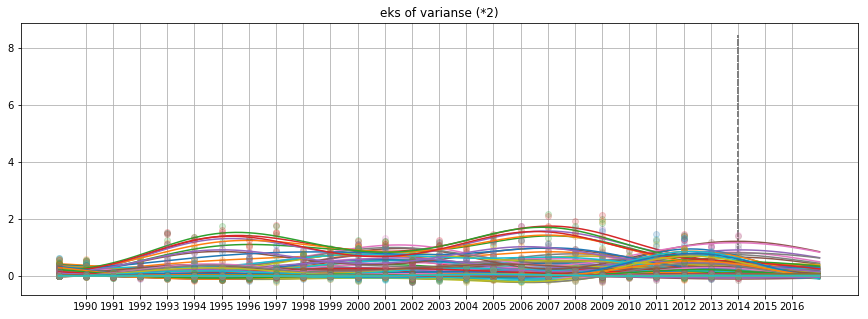

In [24]:
fig = plt.figure(figsize=(15,5))

# random test visual:
start = 1000
end = 1500


for i, j in enumerate(np.unique(pickle_test_space_time['index'])[start:end]):
    
    i = i + start
    
    color = 'C' + str(i)[-1] # reiterates after 9
    
    plt.plot(pickle_test_space_time['year'][i], pickle_test_space_time['mu'][i], color = color)


    plt.plot(X[index == j], y[index == j], 'o' , ms=6, alpha=0.2, color = color)
    plt.vlines(X.max(),0,y.max()*1.2, linestyles='dashed', color = 'gray', label='Last observed year: ' + str(X.max()))



# plt.ylim(0,7)
# plt.xlim(X_new.min(),X_new.max())

plt.title('eks of varianse (*2)')
plt.xticks(np.arange(1990,2017,1))
plt.grid()

plt.show()

In [26]:
file_path = 'df_space.pkl'
output = open(file_path, 'wb') # still not working right!!
pickle.dump(df, output)
output.close()